## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2021-11-04 02:47:43--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.163.80
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.163.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  70.5MB/s    in 4.7s    

2021-11-04 02:47:48 (69.0 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_drop1): Dropout(p=0.25)
  (conv2): Conv2d(32, 36, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_drop2): Dropout(p=0.15)
  (conv3): Conv2d(36, 48, kernel_size=(6, 6), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_drop3): Dropout(p=0.1)
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc6): Linear(in_features=1024, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

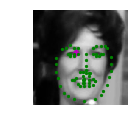

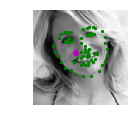

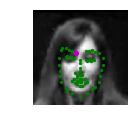

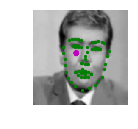

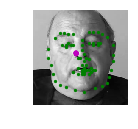

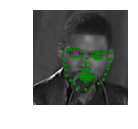

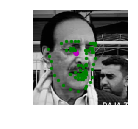

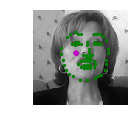

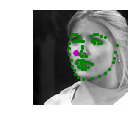

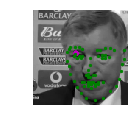

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

#criterion = nn.NLLLoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001)

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr = 0.0001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 16 # start small, and increase when you've decided on your model structure and hyperparams
#print('test conn...')
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.6022478878498078
Epoch: 1, Batch: 20, Avg. Loss: 0.4634890079498291
Epoch: 1, Batch: 30, Avg. Loss: 0.2791985675692558
Epoch: 1, Batch: 40, Avg. Loss: 0.24503896683454512
Epoch: 1, Batch: 50, Avg. Loss: 0.2453797161579132
Epoch: 1, Batch: 60, Avg. Loss: 0.23470378220081328
Epoch: 1, Batch: 70, Avg. Loss: 0.2058573603630066
Epoch: 1, Batch: 80, Avg. Loss: 0.18034788519144057
Epoch: 1, Batch: 90, Avg. Loss: 0.16801855936646462
Epoch: 1, Batch: 100, Avg. Loss: 0.23999497890472413
Epoch: 1, Batch: 110, Avg. Loss: 0.19486356675624847
Epoch: 1, Batch: 120, Avg. Loss: 0.15984069257974626
Epoch: 1, Batch: 130, Avg. Loss: 0.1746991403400898
Epoch: 1, Batch: 140, Avg. Loss: 0.18272849321365356
Epoch: 1, Batch: 150, Avg. Loss: 0.21885908842086793
Epoch: 1, Batch: 160, Avg. Loss: 0.16307208463549613
Epoch: 1, Batch: 170, Avg. Loss: 0.16687485352158546
Epoch: 1, Batch: 180, Avg. Loss: 0.16501082852482796
Epoch: 1, Batch: 190, Avg. Loss: 0.18543866127729416
Epoch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.15929042920470238
Epoch: 2, Batch: 20, Avg. Loss: 0.1970972277224064
Epoch: 2, Batch: 30, Avg. Loss: 0.20869452133774757
Epoch: 2, Batch: 40, Avg. Loss: 0.3248476579785347
Epoch: 2, Batch: 50, Avg. Loss: 0.19116630032658577
Epoch: 2, Batch: 60, Avg. Loss: 0.1894161343574524
Epoch: 2, Batch: 70, Avg. Loss: 0.18664551004767418
Epoch: 2, Batch: 80, Avg. Loss: 0.21916822642087935
Epoch: 2, Batch: 90, Avg. Loss: 0.16288139522075654
Epoch: 2, Batch: 100, Avg. Loss: 0.16713210418820382
Epoch: 2, Batch: 110, Avg. Loss: 0.1747924767434597
Epoch: 2, Batch: 120, Avg. Loss: 0.19570341557264329
Epoch: 2, Batch: 130, Avg. Loss: 0.15479373931884766
Epoch: 2, Batch: 140, Avg. Loss: 0.16675013825297355
Epoch: 2, Batch: 150, Avg. Loss: 0.1506294973194599
Epoch: 2, Batch: 160, Avg. Loss: 0.215862412750721
Epoch: 2, Batch: 170, Avg. Loss: 0.16209568381309508
Epoch: 2, Batch: 180, Avg. Loss: 0.18416843190789223
Epoch: 2, Batch: 190, Avg. Loss: 0.17144273072481156
Epoch: 2,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.1510905183851719
Epoch: 3, Batch: 20, Avg. Loss: 0.17361807227134704
Epoch: 3, Batch: 30, Avg. Loss: 0.1297573782503605
Epoch: 3, Batch: 40, Avg. Loss: 0.14645938351750373
Epoch: 3, Batch: 50, Avg. Loss: 0.16437230184674262
Epoch: 3, Batch: 60, Avg. Loss: 0.16820024847984313
Epoch: 3, Batch: 70, Avg. Loss: 0.14073464050889015
Epoch: 3, Batch: 80, Avg. Loss: 0.1376819647848606
Epoch: 3, Batch: 90, Avg. Loss: 0.1590953692793846
Epoch: 3, Batch: 100, Avg. Loss: 0.11473963633179665
Epoch: 3, Batch: 110, Avg. Loss: 0.11980368569493294
Epoch: 3, Batch: 120, Avg. Loss: 0.141787301748991
Epoch: 3, Batch: 130, Avg. Loss: 0.12642926201224328
Epoch: 3, Batch: 140, Avg. Loss: 0.1502797096967697
Epoch: 3, Batch: 150, Avg. Loss: 0.14883639812469482
Epoch: 3, Batch: 160, Avg. Loss: 0.14791393131017685
Epoch: 3, Batch: 170, Avg. Loss: 0.1612256333231926
Epoch: 3, Batch: 180, Avg. Loss: 0.13800650909543039
Epoch: 3, Batch: 190, Avg. Loss: 0.14724952206015587
Epoch: 3, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.14945491924881935
Epoch: 4, Batch: 20, Avg. Loss: 0.15057175382971763
Epoch: 4, Batch: 30, Avg. Loss: 0.12614449113607407
Epoch: 4, Batch: 40, Avg. Loss: 0.19494614601135254
Epoch: 4, Batch: 50, Avg. Loss: 0.13376093730330468
Epoch: 4, Batch: 60, Avg. Loss: 0.16918530613183974
Epoch: 4, Batch: 70, Avg. Loss: 0.1528228096663952
Epoch: 4, Batch: 80, Avg. Loss: 0.11584632471203804
Epoch: 4, Batch: 90, Avg. Loss: 0.1476012721657753
Epoch: 4, Batch: 100, Avg. Loss: 0.11797018274664879
Epoch: 4, Batch: 110, Avg. Loss: 0.12132231593132019
Epoch: 4, Batch: 120, Avg. Loss: 0.15056202709674835
Epoch: 4, Batch: 130, Avg. Loss: 0.1253901317715645
Epoch: 4, Batch: 140, Avg. Loss: 0.13827823475003242
Epoch: 4, Batch: 150, Avg. Loss: 0.13541968166828156
Epoch: 4, Batch: 160, Avg. Loss: 0.1396307587623596
Epoch: 4, Batch: 170, Avg. Loss: 0.12038629800081253
Epoch: 4, Batch: 180, Avg. Loss: 0.1170476421713829
Epoch: 4, Batch: 190, Avg. Loss: 0.1871504109352827
Epoch: 4

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.11232462376356125
Epoch: 5, Batch: 20, Avg. Loss: 0.12840919941663742
Epoch: 5, Batch: 30, Avg. Loss: 0.15704623758792877
Epoch: 5, Batch: 40, Avg. Loss: 0.1290450982749462
Epoch: 5, Batch: 50, Avg. Loss: 0.132286623865366
Epoch: 5, Batch: 60, Avg. Loss: 0.1637747257947922
Epoch: 5, Batch: 70, Avg. Loss: 0.12921160832047462
Epoch: 5, Batch: 80, Avg. Loss: 0.11881750039756298
Epoch: 5, Batch: 90, Avg. Loss: 0.11474193930625916
Epoch: 5, Batch: 100, Avg. Loss: 0.14361922144889833
Epoch: 5, Batch: 110, Avg. Loss: 0.13424145802855492
Epoch: 5, Batch: 120, Avg. Loss: 0.142256723344326
Epoch: 5, Batch: 130, Avg. Loss: 0.16038090735673904
Epoch: 5, Batch: 140, Avg. Loss: 0.14792341366410255
Epoch: 5, Batch: 150, Avg. Loss: 0.14053771421313285
Epoch: 5, Batch: 160, Avg. Loss: 0.09746230244636536
Epoch: 5, Batch: 170, Avg. Loss: 0.12809756621718407
Epoch: 5, Batch: 180, Avg. Loss: 0.20866003409028053
Epoch: 5, Batch: 190, Avg. Loss: 0.12672228962183
Epoch: 5, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.12147350609302521
Epoch: 6, Batch: 20, Avg. Loss: 0.1847737491130829
Epoch: 6, Batch: 30, Avg. Loss: 0.1456915929913521
Epoch: 6, Batch: 40, Avg. Loss: 0.11074273958802223
Epoch: 6, Batch: 50, Avg. Loss: 0.13448263257741927
Epoch: 6, Batch: 60, Avg. Loss: 0.10325954258441924
Epoch: 6, Batch: 70, Avg. Loss: 0.10594417341053486
Epoch: 6, Batch: 80, Avg. Loss: 0.09077122509479522
Epoch: 6, Batch: 90, Avg. Loss: 0.09995884709060192
Epoch: 6, Batch: 100, Avg. Loss: 0.11823970079421997
Epoch: 6, Batch: 110, Avg. Loss: 0.10584289878606797
Epoch: 6, Batch: 120, Avg. Loss: 0.12179485335946083
Epoch: 6, Batch: 130, Avg. Loss: 0.11313253231346607
Epoch: 6, Batch: 140, Avg. Loss: 0.11275950931012631
Epoch: 6, Batch: 150, Avg. Loss: 0.11206718012690545
Epoch: 6, Batch: 160, Avg. Loss: 0.09853096455335617
Epoch: 6, Batch: 170, Avg. Loss: 0.09577013887465
Epoch: 6, Batch: 180, Avg. Loss: 0.10682502239942551
Epoch: 6, Batch: 190, Avg. Loss: 0.10006888434290886
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.09069804511964322
Epoch: 7, Batch: 20, Avg. Loss: 0.08983162976801395
Epoch: 7, Batch: 30, Avg. Loss: 0.10194325782358646
Epoch: 7, Batch: 40, Avg. Loss: 0.11660968735814095
Epoch: 7, Batch: 50, Avg. Loss: 0.08757932409644127
Epoch: 7, Batch: 60, Avg. Loss: 0.10204412117600441
Epoch: 7, Batch: 70, Avg. Loss: 0.08244868628680706
Epoch: 7, Batch: 80, Avg. Loss: 0.08919230774044991
Epoch: 7, Batch: 90, Avg. Loss: 0.11833785958588124
Epoch: 7, Batch: 100, Avg. Loss: 0.0863136675208807
Epoch: 7, Batch: 110, Avg. Loss: 0.10862422958016396
Epoch: 7, Batch: 120, Avg. Loss: 0.08919154219329357
Epoch: 7, Batch: 130, Avg. Loss: 0.09672494530677796
Epoch: 7, Batch: 140, Avg. Loss: 0.1316100500524044
Epoch: 7, Batch: 150, Avg. Loss: 0.09700875021517277
Epoch: 7, Batch: 160, Avg. Loss: 0.10247260183095933
Epoch: 7, Batch: 170, Avg. Loss: 0.08715599365532398
Epoch: 7, Batch: 180, Avg. Loss: 0.11215215325355529
Epoch: 7, Batch: 190, Avg. Loss: 0.0929066326469183
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.07835200689733028
Epoch: 8, Batch: 20, Avg. Loss: 0.08583976961672306
Epoch: 8, Batch: 30, Avg. Loss: 0.22421154379844666
Epoch: 8, Batch: 40, Avg. Loss: 0.08251277580857277
Epoch: 8, Batch: 50, Avg. Loss: 0.08997897431254387
Epoch: 8, Batch: 60, Avg. Loss: 0.0997431468218565
Epoch: 8, Batch: 70, Avg. Loss: 0.08005262725055218
Epoch: 8, Batch: 80, Avg. Loss: 0.08849189393222331
Epoch: 8, Batch: 90, Avg. Loss: 0.11881650872528553
Epoch: 8, Batch: 100, Avg. Loss: 0.08045976944267749
Epoch: 8, Batch: 110, Avg. Loss: 0.11325357928872108
Epoch: 8, Batch: 120, Avg. Loss: 0.11328811645507812
Epoch: 8, Batch: 130, Avg. Loss: 0.11942590102553367
Epoch: 8, Batch: 140, Avg. Loss: 0.2276331901550293
Epoch: 8, Batch: 150, Avg. Loss: 0.10438743084669114
Epoch: 8, Batch: 160, Avg. Loss: 0.06420536264777184
Epoch: 8, Batch: 170, Avg. Loss: 0.12590613663196565
Epoch: 8, Batch: 180, Avg. Loss: 0.10023388415575027
Epoch: 8, Batch: 190, Avg. Loss: 0.12039126306772233
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.09593840762972831
Epoch: 9, Batch: 20, Avg. Loss: 0.09556915573775768
Epoch: 9, Batch: 30, Avg. Loss: 0.09638694301247597
Epoch: 9, Batch: 40, Avg. Loss: 0.11822999529540539
Epoch: 9, Batch: 50, Avg. Loss: 0.08889415487647057
Epoch: 9, Batch: 60, Avg. Loss: 0.10424265600740909
Epoch: 9, Batch: 70, Avg. Loss: 0.09834234341979027
Epoch: 9, Batch: 80, Avg. Loss: 0.10133477300405502
Epoch: 9, Batch: 90, Avg. Loss: 0.06830590516328812
Epoch: 9, Batch: 100, Avg. Loss: 0.08105625957250595
Epoch: 9, Batch: 110, Avg. Loss: 0.07338381931185722
Epoch: 9, Batch: 120, Avg. Loss: 0.1101353034377098
Epoch: 9, Batch: 130, Avg. Loss: 0.08443228155374527
Epoch: 9, Batch: 140, Avg. Loss: 0.07616063579916954
Epoch: 9, Batch: 150, Avg. Loss: 0.0813337929546833
Epoch: 9, Batch: 160, Avg. Loss: 0.09974994771182537
Epoch: 9, Batch: 170, Avg. Loss: 0.1073315478861332
Epoch: 9, Batch: 180, Avg. Loss: 0.0661062017083168
Epoch: 9, Batch: 190, Avg. Loss: 0.11521755196154118
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.09943513460457325
Epoch: 10, Batch: 20, Avg. Loss: 0.08155124001204968
Epoch: 10, Batch: 30, Avg. Loss: 0.10760241933166981
Epoch: 10, Batch: 40, Avg. Loss: 0.056624560803174975
Epoch: 10, Batch: 50, Avg. Loss: 0.08082417733967304
Epoch: 10, Batch: 60, Avg. Loss: 0.12084459066390991
Epoch: 10, Batch: 70, Avg. Loss: 0.089153141528368
Epoch: 10, Batch: 80, Avg. Loss: 0.0701061762869358
Epoch: 10, Batch: 90, Avg. Loss: 0.14695674180984497
Epoch: 10, Batch: 100, Avg. Loss: 0.10566593185067177
Epoch: 10, Batch: 110, Avg. Loss: 0.09057181663811206
Epoch: 10, Batch: 120, Avg. Loss: 0.061839929595589635
Epoch: 10, Batch: 130, Avg. Loss: 0.07602433636784553
Epoch: 10, Batch: 140, Avg. Loss: 0.08655620403587819
Epoch: 10, Batch: 150, Avg. Loss: 0.07623977921903133
Epoch: 10, Batch: 160, Avg. Loss: 0.09248153194785118
Epoch: 10, Batch: 170, Avg. Loss: 0.10748503841459751
Epoch: 10, Batch: 180, Avg. Loss: 0.08188022002577781
Epoch: 10, Batch: 190, Avg. Loss: 0.09

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.0901271492242813
Epoch: 11, Batch: 20, Avg. Loss: 0.07972789444029331
Epoch: 11, Batch: 30, Avg. Loss: 0.0777952540665865
Epoch: 11, Batch: 40, Avg. Loss: 0.06101449616253376
Epoch: 11, Batch: 50, Avg. Loss: 0.059991026669740675
Epoch: 11, Batch: 60, Avg. Loss: 0.09078200086951256
Epoch: 11, Batch: 70, Avg. Loss: 0.15214028321206569
Epoch: 11, Batch: 80, Avg. Loss: 0.13439306914806365
Epoch: 11, Batch: 90, Avg. Loss: 0.05925401207059622
Epoch: 11, Batch: 100, Avg. Loss: 0.08450518362224102
Epoch: 11, Batch: 110, Avg. Loss: 0.10867579504847527
Epoch: 11, Batch: 120, Avg. Loss: 0.08022079579532146
Epoch: 11, Batch: 130, Avg. Loss: 0.0802352074533701
Epoch: 11, Batch: 140, Avg. Loss: 0.09978032559156418
Epoch: 11, Batch: 150, Avg. Loss: 0.09376853816211224
Epoch: 11, Batch: 160, Avg. Loss: 0.13228954821825029
Epoch: 11, Batch: 170, Avg. Loss: 0.06882190257310868
Epoch: 11, Batch: 180, Avg. Loss: 0.0759967289865017
Epoch: 11, Batch: 190, Avg. Loss: 0.0710

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.09824378415942192
Epoch: 12, Batch: 20, Avg. Loss: 0.07515109702944756
Epoch: 12, Batch: 30, Avg. Loss: 0.07188016697764396
Epoch: 12, Batch: 40, Avg. Loss: 0.05452224723994732
Epoch: 12, Batch: 50, Avg. Loss: 0.12809107191860675
Epoch: 12, Batch: 60, Avg. Loss: 0.06174407564103603
Epoch: 12, Batch: 70, Avg. Loss: 0.059164108335971834
Epoch: 12, Batch: 80, Avg. Loss: 0.06808491870760917
Epoch: 12, Batch: 90, Avg. Loss: 0.07799756899476051
Epoch: 12, Batch: 100, Avg. Loss: 0.06652731895446777
Epoch: 12, Batch: 110, Avg. Loss: 0.066189319267869
Epoch: 12, Batch: 120, Avg. Loss: 0.06088045462965965
Epoch: 12, Batch: 130, Avg. Loss: 0.08229958973824977
Epoch: 12, Batch: 140, Avg. Loss: 0.06901975683867931
Epoch: 12, Batch: 150, Avg. Loss: 0.06333122942596674
Epoch: 12, Batch: 160, Avg. Loss: 0.05966769754886627
Epoch: 12, Batch: 170, Avg. Loss: 0.07426778804510832
Epoch: 12, Batch: 180, Avg. Loss: 0.07896030768752098
Epoch: 12, Batch: 190, Avg. Loss: 0.08

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.06805331520736217
Epoch: 13, Batch: 20, Avg. Loss: 0.08860043529421091
Epoch: 13, Batch: 30, Avg. Loss: 0.0636984083801508
Epoch: 13, Batch: 40, Avg. Loss: 0.051995267160236835
Epoch: 13, Batch: 50, Avg. Loss: 0.10816210322082043
Epoch: 13, Batch: 60, Avg. Loss: 0.10191319771111011
Epoch: 13, Batch: 70, Avg. Loss: 0.14990706481039523
Epoch: 13, Batch: 80, Avg. Loss: 0.07824766859412194
Epoch: 13, Batch: 90, Avg. Loss: 0.05936857052147389
Epoch: 13, Batch: 100, Avg. Loss: 0.07072520032525062
Epoch: 13, Batch: 110, Avg. Loss: 0.06818049624562264
Epoch: 13, Batch: 120, Avg. Loss: 0.10280611626803875
Epoch: 13, Batch: 130, Avg. Loss: 0.06392312832176686
Epoch: 13, Batch: 140, Avg. Loss: 0.09437689483165741
Epoch: 13, Batch: 150, Avg. Loss: 0.09026996791362762
Epoch: 13, Batch: 160, Avg. Loss: 0.07403574697673321
Epoch: 13, Batch: 170, Avg. Loss: 0.06520624607801437
Epoch: 13, Batch: 180, Avg. Loss: 0.05959642790257931
Epoch: 13, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.06981385592371225
Epoch: 14, Batch: 20, Avg. Loss: 0.08359125033020973
Epoch: 14, Batch: 30, Avg. Loss: 0.07027905732393265
Epoch: 14, Batch: 40, Avg. Loss: 0.07598331943154335
Epoch: 14, Batch: 50, Avg. Loss: 0.0667432952672243
Epoch: 14, Batch: 60, Avg. Loss: 0.06770490594208241
Epoch: 14, Batch: 70, Avg. Loss: 0.10288578011095524
Epoch: 14, Batch: 90, Avg. Loss: 0.07892830483615398
Epoch: 14, Batch: 100, Avg. Loss: 0.05665188990533352
Epoch: 14, Batch: 110, Avg. Loss: 0.05060142241418362
Epoch: 14, Batch: 120, Avg. Loss: 0.13488878440111876
Epoch: 14, Batch: 130, Avg. Loss: 0.06446796841919422
Epoch: 14, Batch: 140, Avg. Loss: 0.05447275023907423
Epoch: 14, Batch: 150, Avg. Loss: 0.08437300100922585
Epoch: 14, Batch: 160, Avg. Loss: 0.053232908621430396
Epoch: 14, Batch: 170, Avg. Loss: 0.0765221033245325
Epoch: 14, Batch: 180, Avg. Loss: 0.0641695786267519
Epoch: 14, Batch: 190, Avg. Loss: 0.12485895119607449
Epoch: 14, Batch: 200, Avg. Loss: 0.09

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.05213722512125969
Epoch: 15, Batch: 20, Avg. Loss: 0.07003009803593159
Epoch: 15, Batch: 30, Avg. Loss: 0.06001786328852177
Epoch: 15, Batch: 40, Avg. Loss: 0.07518149688839912
Epoch: 15, Batch: 50, Avg. Loss: 0.09212101586163043
Epoch: 15, Batch: 60, Avg. Loss: 0.258153273537755
Epoch: 15, Batch: 70, Avg. Loss: 0.08506966345012187
Epoch: 15, Batch: 80, Avg. Loss: 0.084695378318429
Epoch: 15, Batch: 90, Avg. Loss: 0.06259757950901985
Epoch: 15, Batch: 100, Avg. Loss: 0.06758843492716551
Epoch: 15, Batch: 110, Avg. Loss: 0.07478247731924056
Epoch: 15, Batch: 120, Avg. Loss: 0.04702459368854761
Epoch: 15, Batch: 130, Avg. Loss: 0.05330513529479504
Epoch: 15, Batch: 140, Avg. Loss: 0.0847045499831438
Epoch: 15, Batch: 150, Avg. Loss: 0.07954511195421218
Epoch: 15, Batch: 160, Avg. Loss: 0.07211864963173867
Epoch: 15, Batch: 170, Avg. Loss: 0.05454594884067774
Epoch: 15, Batch: 180, Avg. Loss: 0.06538678854703903
Epoch: 15, Batch: 190, Avg. Loss: 0.078646

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.0841257281601429
Epoch: 16, Batch: 20, Avg. Loss: 0.055417409911751744
Epoch: 16, Batch: 30, Avg. Loss: 0.11902139596641063
Epoch: 16, Batch: 40, Avg. Loss: 0.055489587411284444
Epoch: 16, Batch: 50, Avg. Loss: 0.05784622263163328
Epoch: 16, Batch: 60, Avg. Loss: 0.07038820050656795
Epoch: 16, Batch: 70, Avg. Loss: 0.05395255442708731
Epoch: 16, Batch: 80, Avg. Loss: 0.0652330307289958
Epoch: 16, Batch: 90, Avg. Loss: 0.07731021288782358
Epoch: 16, Batch: 100, Avg. Loss: 0.07886730991303921
Epoch: 16, Batch: 110, Avg. Loss: 0.07820444405078888
Epoch: 16, Batch: 120, Avg. Loss: 0.06330655217170715
Epoch: 16, Batch: 130, Avg. Loss: 0.06377151273190976
Epoch: 16, Batch: 140, Avg. Loss: 0.07041408233344555
Epoch: 16, Batch: 150, Avg. Loss: 0.053775891102850436
Epoch: 16, Batch: 160, Avg. Loss: 0.1964234035462141
Epoch: 16, Batch: 170, Avg. Loss: 0.05992627330124378
Epoch: 16, Batch: 180, Avg. Loss: 0.07384655307978391
Epoch: 16, Batch: 190, Avg. Loss: 0.0

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


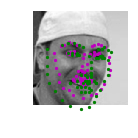

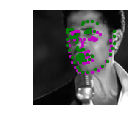

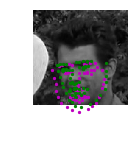

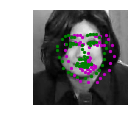

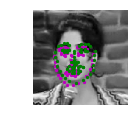

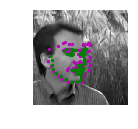

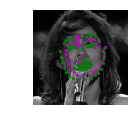

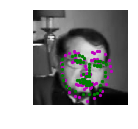

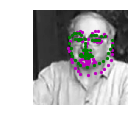

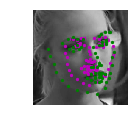

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [25]:
## TODO: change the name to something uniqe for each new model
import time
import datetime

#generate something unique enough for model name
ts = str(time.time())

model_dir = 'saved_models/'
model_name = 'keypoints_model_'+ ts +'.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I choose mean squared error (MSELOSS) because I would like to large errors to be quadratically penalized than small ones given the human face shapes (and keypoints) are normally distributed around a mean value.
I choose Adam optimization because it's computationally efficient with less memory requirements.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with two layers, and slowly adding one, two, three more layers to compare the differences out of curiosity. I insert dropout function on the 1st, 2nd and 3rd layers with a decreasing rate to avoid overfitting. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: For batch_size, since I am using Mini-Batch Gradient Descent (1 < Batch Size < Size of Training Set), I tested different batch sizes and decide to use the default 10. For epochs, I tried to increase the epochs number to 2, 4, 8, 16 and 32, and decide to use 16 since I have noticed at around 16 it gives me the best result within the limited time span.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.18352439 -0.02638036  0.14226101 -0.08178477  0.19761319]
 [ 0.08506114  0.0127972   0.03390062  0.16480877 -0.13704215]
 [-0.08371496 -0.15891826  0.02769485 -0.06821799 -0.02413741]
 [-0.0118958   0.01068963 -0.15653495  0.11309129 -0.02631543]
 [-0.12733969 -0.0827603   0.0523273   0.07901711  0.13828678]]
(5, 5)


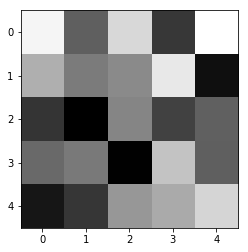

In [19]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

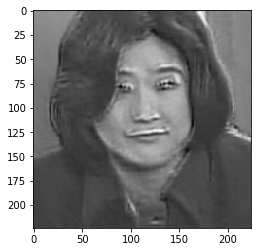

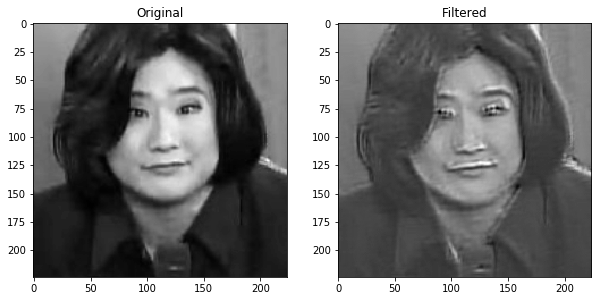

In [34]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2
import numpy as np
import random

%matplotlib inline
#sample_id = random.randrange(0, 10, 3)
sample_id = 3
sample_img = np.squeeze(test_images[sample_id].data)

sample_img = sample_img.numpy()  
#print('test conn...')
fil=w[filter_index][0]
filtered_img = cv2.filter2D(sample_img, -1, fil)
plt.imshow(filtered_img, cmap='gray')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('Original')
ax1.imshow(sample_img, cmap='gray')

ax2.set_title('Filtered')
ax2.imshow(filtered_img, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: I chose image 3. Comparing the image before and after, it seems the filter has edge detection/highlighting function, with certain degree of denoise or smoothing effect. I think it detects fhe feature of eye brow, eye lid, pupil, nose bridge, lips and chin.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!